# Week 11 Midterm: NLP

**Brian Roepke**  
*DATA 110*

# Overview

As a clothing retailer with an e-Commerce presece, it's importtant for us to understand what customers are saying about our products, which products are most popular with our customers and how we can improve our offerings.  In order to accomplish this we'll take a look at a number of different analyses that will help with the following:

1. **Review Trends**: General trends of customer reviews, quantity, distribution, etc.
1. **Sentiment Analysis**:  How customers feel about the products; are the positive or negative generally.
1. **Part of Speech Analysis**: Using different parts or speech (Nouns, Verbs, Adjectives, etc.).  Via this we can see the most common positive and negative words used to describe products as well as which a the most commonly referenced products categories.
1. **Reccomendation Prediction**: We will use this customer sentiment to better understand if a customer will give a positive rating on the cloting items based on their review.
1. **Department Prediction**: Finally, we'll use a multi-classification machine learning model to predict the departements a product belongs to based on the description that's being used.  This might identify cross-selling oportunities or cross-listing opportunities for products in new categories.

![](https://github.com/broepke/DATA110/blob/main/Week%2011/clothing.jpg?raw=true)
<a href='https://www.freepik.com/vectors/woman'>Woman vector created by freepik - www.freepik.com</a>

In [137]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from textblob import Word

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier

# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize
from nltk.sentiment.util import *
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing & EDA

Importing our dataset and providing the necessary cleaning and analysis.

In [3]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


In [5]:
# Change to Categorical types
df["Department Name"] = df["Department Name"].astype('category')
df["Class Name"] = df["Class Name"].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      23486 non-null  int64   
 1   Title                    19676 non-null  object  
 2   Review Text              22641 non-null  object  
 3   Rating                   23486 non-null  int64   
 4   Recommended IND          23486 non-null  int64   
 5   Positive Feedback Count  23486 non-null  int64   
 6   Department Name          23472 non-null  category
 7   Class Name               23472 non-null  category
dtypes: category(2), int64(4), object(2)
memory usage: 1.1+ MB


In [7]:
df.shape

(23486, 8)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [8]:
# check for nan/null
df.isnull().values.any()

True

In [9]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name              14
Class Name                   14
dtype: int64

In [10]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

**Note**: The null values for the lower counts (except `Title`) were dropped from the dataset.

In [11]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name               0
Class Name                    0
dtype: int64

In [12]:
# fill the NA values with 0
df['Title'].fillna('', inplace=True)

**Note**: Any `NULL` values for the title field are filled with blank strings.  Next these will be combined with the `Review Text` field so we have a single text field for analysis.

In [13]:
# count of nulls
df.isnull().sum()

Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Department Name            0
Class Name                 0
dtype: int64

In [14]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [15]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

In [16]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [18]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before-len_after)

Before = 22628
After = 22626

Total Removed = 2


**Note**: After the prior clean up of `NULL` values, there were just `2` duplicates left.

### Numeric Variables

In [17]:
df.describe()

,Age,Rating,Recommended IND,Positive Feedback Count,text_len
count,22628.000000,22628.000000,22628.000000,22628.000000,22628.000000
mean,43.282880,4.183092,0.818764,2.631784,326.357036
std,12.328176,1.115911,0.385222,5.787520,147.283745
min,18.000000,1.000000,0.000000,0.000000,12.000000
25%,34.000000,4.000000,1.000000,0.000000,201.000000
50%,41.000000,5.000000,1.000000,1.000000,319.000000
75%,52.000000,5.000000,1.000000,3.000000,478.000000
max,99.000000,5.000000,1.000000,122.000000,557.000000


**Observations:** 

1. The age ranges for the dataset range from `18` to `99` with a mean of `43`.  Most shoppers are middled aged with our store.
1. Ratings are based on `1-5` star system.  Mean rating is `4.18` meaning most people give positive reviews. 
1. Positive feedback count is the number of times that people found a review useful.  the mean is `2.63` with a min of `0` and max of `122`

### Categorical Variables

In [19]:
# get categorical data
cat_data = df.select_dtypes(include=['category'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22626 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Department Name  22626 non-null  category
 1   Class Name       22626 non-null  category
dtypes: category(2)
memory usage: 221.9 KB


In [20]:
# show counts values of each categorical variable
for colname in cat_data.columns:
    print (colname)
    print (cat_data[colname].value_counts(), '\n')

Department Name
Tops        10048
Dresses      6145
Bottoms      3661
Intimate     1652
Jackets      1002
Trend         118
Name: Department Name, dtype: int64 

Class Name
Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1103
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               331
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: Class Name, dtype: int64 



**Observations:**  

The categorical values are extermely clean and well labled.  We can look at the distributions of these better via visualization in the next section.

## EDA

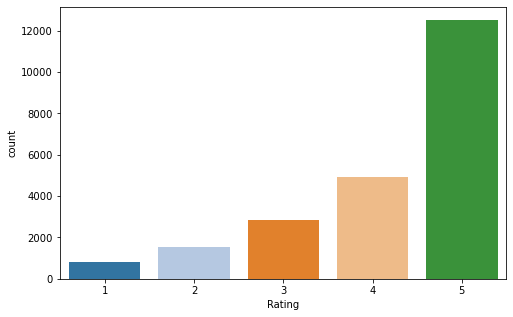

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x='Rating', data=df, palette="tab20", dodge=False);

**Notes:** As observed in the prior section, the reviews are skewed to the postive.

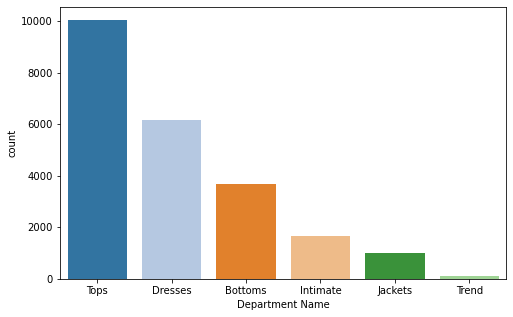

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x='Department Name', data=df, palette="tab20", 
              order = df['Department Name'].value_counts().index, dodge=False);

**Notes**:  

1. `Tops` followed by `Dresses` are the largest categories.  
1. There are very few `Trend` and `Jackets` in the product line.  Predictions will be harder on these imbalanced classes.

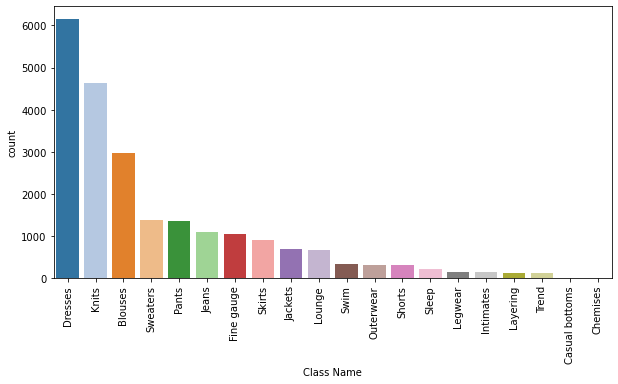

In [23]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Class Name', data=df, palette="tab20", 
                   order = df['Class Name'].value_counts().index, dodge=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

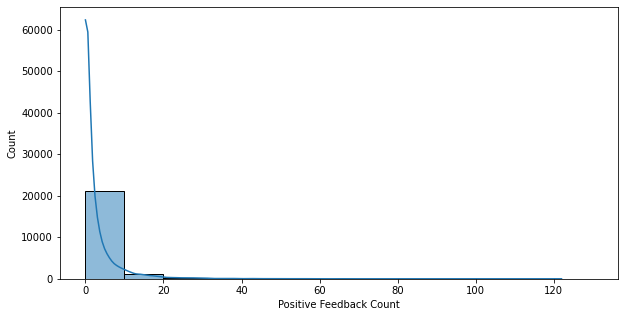

In [129]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(df, x='Positive Feedback Count', kde=True, palette="tab20c", binwidth=10);
# ax.set(yscale="log");

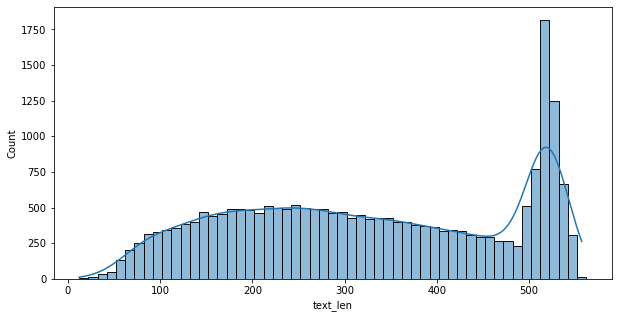

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_len', kde=True, palette="tab20c", binwidth=10);
# ax.set(yscale="log");

**Notes**: For the `text_len` attribute, there is a fairly even distribution from `100` to `400` characters and then a higher concentration of reviews that are longer, around `500` characters.  Given that there are not massive outliers here, the number of characters of the reviews is probably limited to `~600~` chars.

## Text Cleaning

For the analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

In [26]:
df['Text'][2]

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [27]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [28]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x, stem='Lem'))

In [29]:
df['Text_Processed'][2]

'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

# Sentiment Analysis

For our sentiment analysis section, we will be using the `TextBlob` package to assist in creating `polarity scores` or sentiment scores that range from `-1` to `1` where lower scores are more negative and higher more positive.  Based off of these scores, we'll add a classifier of `1` for positive and `0` for negative to be used later in our prediction model. 

In [31]:
def get_sentiment(x):
    '''using TextBlob, get the sentiment score for a given body of text'''
    blob = TextBlob(x)
    return blob.sentiment.polarity

In [32]:
# Apply the Polarity Scoring from TextBlob
df['sentiment'] = df['Text_Processed'].apply(lambda x: get_sentiment(x))

In [33]:
# Create a few extra columns to aid in the analysis
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x >= 0 else 0)

In [131]:
df[df.columns[-3:]].head()

,sentiment,sentiment_label,Text_Tok
0,0.633333,1,"[absolutely, wonderful, silky, sexy, comfortable]"
1,0.318750,1,"[love, dress, sooo, pretty, happened, find, store, im, glad, bc, never, would, ordered, online, bc, petite, bought, petite, 58, love, length, hit, little, knee, would, definitely, true, midi, someone, truly, petite]"
2,0.081439,1,"[major, design, flaw, high, hope, dress, really, wanted, work, initially, ordered, petite, small, usual, size, found, outrageously, small, small, fact, could, zip, reordered, petite, medium, ok, overall, top, half, comfortable, fit, nicely, bottom, half, tight, layer, several, somewhat, cheap, net, layer, imo, major, design, flaw, net, layer, sewn, directly, zipper, c]"
3,0.500000,1,"[favorite, buy, love, love, love, jumpsuit, fun, flirty, fabulous, every, time, wear, get, nothing, great, compliment]"
4,0.458333,1,"[flattering, shirt, shirt, flattering, due, adjustable, front, tie, perfect, length, wear, legging, sleeveless, pair, well, cardigan, love, shirt]"


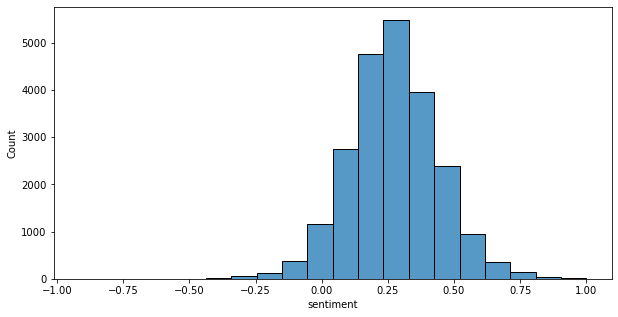

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='sentiment', palette="tab20c", bins=20);

**Observations:**

The distributions of sentiment, similar to the `1-5` star reviews is left skewed to the positive.  There are very few that have a `<0` polartity score.

In [135]:
len(df[df['sentiment'] == 0])

83

**Note**: There are a small number (`83`) of reviews that received a `neutral` sentiment.  Since this number is so low, a `0` rating was grouped together with the majority class (`positive`).

# Part-of-speech Tagging

- show word counts for different parts of speech 
- What are popular products? identify nouns that can be used to tag the product (eg: dress, jacket, bottom, etc) and show their counts
- Identify the top adjectives and adverbs for positive vs negative reviews 

In [36]:
# Tokenize the words
df['Text_Tok'] = df['Text_Processed'].apply(word_tokenize)

In [37]:
def parse_text(x):
    '''using TextBlob, get the full parsed results (POS, etc)'''
    blob = TextBlob(x)
    p = blob.parse()
    p = re.sub(r'^\w+/', '',p)
    return p.split('/')

In [38]:
def build_pos(x):
    '''pass a DataFrame column with tokenized text and return a DF of the Words'''
    all_words = []
    for l in x:
        all_words = all_words + l
        
    df = pd.DataFrame(all_words)
    df.columns = ['Word']
    
    # Add a column for the POS
    df['Parse'] = df['Word'].apply(lambda x: parse_text(x))
    
    # Expned the extracted list of POS tags into their own columns, and concat that back to the orig DF
    # https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/
    par = pd.DataFrame(df['Parse'].to_list(), columns=['P1','P2', 'P3', 'P4'])
    df = pd.concat([df[:], par[:]], axis=1)
    df.drop(columns=['Parse'], inplace=True)

    return df

In [39]:
df_words = build_pos(df['Text_Tok'])

In [40]:
df_words.sample(10)

,Word,P1,P2,P3,P4
369282,sweater,NN,B-NP,O,None
647104,cute,JJ,B-ADJP,O,None
393029,pretty,RB,B-ADVP,O,None
612408,without,IN,B-PP,O,None
511156,tunic,NN,B-NP,O,None
710152,also,RB,B-ADVP,O,None
440829,house,NN,B-NP,O,None
283387,dry,JJ,B-ADJP,O,None
204547,dress,NN,B-NP,O,None
597763,color,NN,B-NP,O,None


**Notes:** Rather than using the much simpler approach of the POS with the TextBlog `tags` function[1], the `parse` function was used since it provides a more verpose labeling of the text.

The attempt here was to try to discover if there was a better way to identify nouns that would better represent product features vs. other nouns.  Unfortunatley this didn't end up providing the detail needed. More information on this is presented below.

## Word Counts for Different Parts of Speech

In [41]:
df_top_pos = df_words.groupby('P1')['P1'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(15)

In [42]:
df_top_pos

,P1,count
10,NN,269428
6,JJ,166542
20,VB,65332
16,RB,54957
21,VBD,37820
23,VBN,23676
1,CD,19369
5,IN,17498
22,VBG,16842
24,VBP,13959


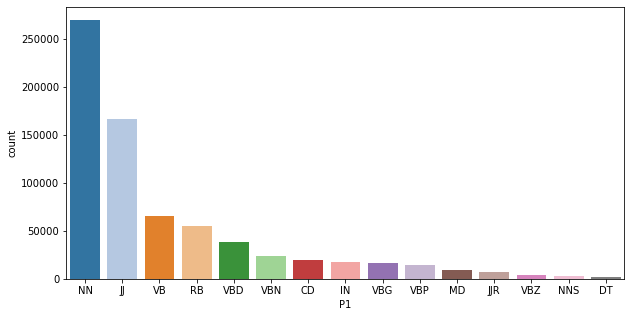

In [140]:
plt.figure(figsize=(10,5))
sns.barplot(data =df_top_pos, x='P1', y='count', palette="tab20");

## Identify Top Product Nouns

In [44]:
df_nn = df_words[df_words['P1'] == 'NN'].copy()

In [45]:
df_nn.groupby('Word')['Word'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,Word,count
2994,dress,12970
5449,love,10812
8332,size,9572
2151,color,7357
3371,fabric,5127
9078,sweater,3112
8139,shirt,3099
1219,bit,2947
5633,material,2922
4851,jean,2848


**Notes**:  When inspecting `nouns` only, there is a mix of different types of words displayed and some we can see are not tagged in such a way that seems to make sense with this dataset.  For example `love` is tagged as a noun but it's probably an adjective.  `bit` is probably referrring to a adjective as well but is showing as a noun.

We can sinepect these words directly to see if there is a difference in their POS tags.

In [141]:
print(TextBlob('dress').parse())
print(TextBlob('love').parse())
print(TextBlob('bit').parse())

dress/NN/B-NP/O
love/NN/B-NP/O
bit/NN/B-NP/O


**Observations:**  When we try to use the Part of Speech (POS) tagging there isn't a distinction between Nouns.  Each of these have eactly the same POS sequence. 

We can use the Class name to determine clothing nouns to use.  

In [47]:
# Extract a list of all the unique class names
noun_types = list(df['Class Name'].unique())

# The words from the categories need to be lemmatized.
lem = WordNetLemmatizer()
for i in range(len(noun_types)):
    noun_types[i] = lem.lemmatize(noun_types[i].lower())
noun_types

['intimate',
 'dress',
 'pant',
 'blouse',
 'knit',
 'outerwear',
 'lounge',
 'sweater',
 'skirt',
 'fine gauge',
 'sleep',
 'jacket',
 'swim',
 'trend',
 'jean',
 'legwear',
 'short',
 'layering',
 'casual bottoms',
 'chemise']

In [48]:
# Extract all the text into a huge string and use Text Blobs to get a Dictionary out with counts
all_text = ' '.join(df['Text_Processed'])
all_text_blob = TextBlob(all_text)
all_text_dict = all_text_blob.word_counts

# Turn the dictionary into a Dataframe.  Filter by the word list and then sort for plotting.
df_dict = pd.DataFrame(list(all_text_dict.items()),columns = ['Word','Count']) 
df_products = df_dict[df_dict.Word.isin(noun_types)]
df_products.sort_values(by=['Count'], inplace=True, ascending=False)
df_products

,Word,Count
6,dress,12970
455,sweater,3112
362,jean,2848
460,short,2594
104,skirt,2480
154,pant,2366
512,jacket,1477
340,blouse,1188
506,knit,485
492,layering,258


**Observations:**: Based on the top outputs we can see that `dresses` are the largest mentioned product line at a rate of `4x` the second, `sweaters`.

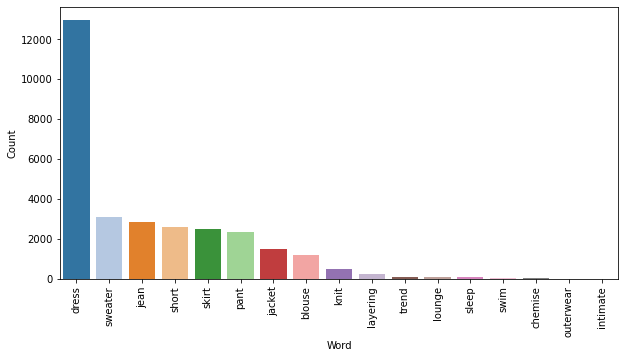

In [49]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Word', y='Count', data=df_products, palette="tab20", dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Top Adjectives and Adverbs for Positive vs Negative Reviews

Using Part of Speech taggs, we can look at which adjectives and adverbs people are using most to describe the products.  Below is a table that shows how different parts of speech are encoded in this system.
 
**Part of Speech Codes**

<table align="left" cellpadding="2" cellspacing="2" border="0">
  <tbody><tr bgcolor="#DFDFFF" align="none"> 
    <td align="none"> 
      <div align="left">Number</div>
    </td>
    <td> 
      <div align="left">Tag</div>
    </td>
    <td> 
      <div align="left">Description</div>
    </td>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 7. </td>
    <td>JJ </td>
    <td>Adjective </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 8. </td>
    <td>JJR </td>
    <td>Adjective, comparative </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 9. </td>
    <td>JJS </td>
    <td>Adjective, superlative </td>
  </tr>

  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 20. </td>
    <td>RB </td>
    <td>Adverb </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 21. </td>
    <td>RBR </td>
    <td>Adverb, comparative </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 22. </td>
    <td>RBS </td>
    <td>Adverb, superlative </td>
  </tr>
  
</td></tr></tbody></table>
 

In [50]:
# Extract pos and neg reviews based on sentiment into their own DFs
df_pos = df[df['sentiment_label'] == 1]
df_neg = df[df['sentiment_label'] == 0]

# Drop the rest of the columns after separating
df_pos = df_pos[['Text_Tok']]
df_neg = df_neg[['Text_Tok']]

In [51]:
def get_top_mods(df_all_words):
    ''' this function will return a dataframe of the top adjetives and 
    adverbs group together and counted'''
    
    df_mods = df_all_words[(df_all_words.P1.str.startswith('JJ')) | (df_all_words.P1.str.startswith('RB'))]

    # Groupby, count, sort in order to get the counts of the words
    df_grouped = df_mods.groupby(['P1', 'Word'])['Word'].count().\
        reset_index(name='count').sort_values(['count'],ascending=False)

    # Convert to Multi-Level Index
    df_grouped.set_index(['P1', 'Word'], inplace=True)

    # Finally, just display the top 3 (if there are 3)
    return df_grouped.groupby(level=0).head(5)

In [52]:
# Build the Dataframe via the Function
df_all_words_pos = build_pos(df_pos['Text_Tok'])

# Get the top words
get_top_mods(df_all_words_pos)

count
P1  Word          
JJ  top       9293
    great     7817
    perfect   4525
    cute      4455
    small     4422
RB  really    3898
    well      3228
    back      3035
    pretty    2755
    also      2403
JJR better    1327
JJS best       642
JJR smaller    616
    shorter    595
    larger     540
JJS least      294
JJR bigger     256
JJS softest     56
    cutest      56
    biggest     47
RBR earlier     41
    sooner       6
    neater       2
    faster       2

In [53]:
# Build the Dataframe via the Function
df_all_words_neg = build_pos(df_neg['Text_Tok'])

# Get the top words
get_top_mods(df_all_words_neg)

count
P1  Word            
JJ  small        476
RB  back         227
JJ  little       211
    thin         183
RB  also         174
    really       171
    even         170
JJ  tight        147
    short        145
RB  usually      124
JJR smaller       36
JJS least         36
JJR shorter       35
    better        30
    larger        29
JJS worst         23
JJR bigger        19
JJS longest        2
RBR faster         2
JJS cutest         2
    strangest      1

**Notes**:

Above are the most frequently occuring positive and negative words per Adjective and Adverb.  

1. **Positive**: Top words are `top`, `great`, `perfect`, `really`, and `pretty`
1. **Negative**: Top words are `small`, `little`, `thin`, `tight`, and `short`

None of the words really are suprising with the positive words, but with the negative words there appears to be a **sizing issue** where products are smaller than people expect vs. the sizes claimed. 

# Prediction Model:

create a Supervised ML model to predict whether a product will be Recommended (this is your target),  based on the text features from  (Text) along with the numeric features (text_len, polarity_score)  

**Note on Column Transformer**:

https://stackoverflow.com/questions/55604249/featureunion-vs-columntransformer

In [54]:
X = df[['Text', 'sentiment', 'text_len']]
y = df['sentiment_label']

In [55]:
print(X.shape)
print(y.shape)

(22626, 3)
(22626,)


In [56]:
def col_trans():
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(stop_words='english'), 'Text'),
             ('Text Length', MinMaxScaler(), ['text_len']),
             ('Sentiment', MinMaxScaler(), ['sentiment'])],
            remainder='drop') 
    
    return column_trans

In [57]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [58]:
models = {'ComplementNB' : ComplementNB(),
          'SVC' : SVC(class_weight='balanced', random_state=42),
          'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
          'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

ComplementNB : Mean f1 Macro: 0.642 and Standard Deviation: (0.015)
SVC : Mean f1 Macro: 0.920 and Standard Deviation: (0.014)
LogReg : Mean f1 Macro: 0.895 and Standard Deviation: (0.014)
RandomForest : Mean f1 Macro: 0.901 and Standard Deviation: (0.031)


**Observations**:

The **Support Vector Machine** Classifier performed the best with the **Random Forest** and **Logistic Regression** behind it.  Complement Naive Bayes performed the worst. 

`SVC` is a fairly computationally expensive algorithm, it might be advantages to use Logistic Regression if performance were top prioroty.

## Train-Test Split

In [59]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [60]:
print(y_train.shape)
print(X_train.shape)

(15159,)
(15159, 3)


In [61]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, cv=cv, error_score='raise')
    grid.fit(X, y)

    return grid

In [62]:
parameters = [{'clf__C': np.linspace(.1, 2 ,5), 
               'clf__gamma': np.linspace(.1, 1, 5), 
               'clf__class_weight' : ['balanced']}]

clf = SVC()
pipeline = create_pipe(clf)
grid = get_params(parameters, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

svc_C = grid.best_params_['clf__C']
svc_gamma = grid.best_params_['clf__gamma']

Best cross-validation accuracy: 0.917
Test set score: 0.915
Best parameters: {'clf__C': 1.05, 'clf__class_weight': 'balanced', 'clf__gamma': 0.1}


## Model Validation

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [64]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1])

              precision    recall  f1-score   support

           0      0.767     0.928     0.840       359
           1      0.996     0.986     0.991      7108

    accuracy                          0.983      7467
   macro avg      0.882     0.957     0.915      7467
weighted avg      0.985     0.983     0.984      7467

Confusion matrix, without normalization


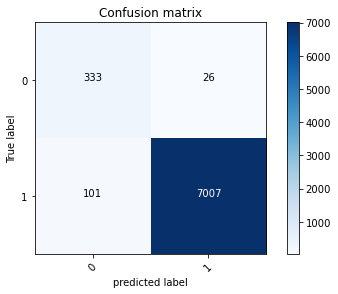

In [65]:
clf = SVC(C=svc_C, gamma=svc_gamma, class_weight='balanced', random_state=42)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'SVC')

## Test on Custom Data

In [66]:
def create_test_data(x):
    '''calculate the numbers needed to run on custom data including sentiment and text length,
    this is a farily simple process using the fuctions from previous transformations.'''
    
    x = process_string(x)
    sent = get_sentiment(x)
    length = len(x)
    
    d = {'Text' : x,
         'sentiment' : sent,
        'text_len' : length}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [67]:
revs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
     'This skirt has really horible quality and I hate it!',
     'A super cute top with the perfect fit.',
     'The most gorgeous pair of jeans I have seen.',
     'this item is too little and tight.']

In [68]:
print('The classifier will return 1 for Positive reviews and 0 for Negative reviews:','\n')
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev, '=', c_res)

The classifier will return 1 for Positive reviews and 0 for Negative reviews: 

This dress is gorgeous and I love it and would gladly reccomend it to all of my friends. = [1]
This skirt has really horible quality and I hate it! = [0]
A super cute top with the perfect fit. = [1]
The most gorgeous pair of jeans I have seen. = [1]
this item is too little and tight. = [0]


# Text Classification Model

- Create a Supervised ML model to classify products by Department (this is your target) 

In [ ]:
# Tokenize the words
df['Department Name'] = df['Department Name'].apply(word_tokenize)

In [70]:
X = df[['Text', 'Department Name']]
y = df['Department Name']

In [71]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [72]:
print(X.shape)
print(y.shape)
print(mlb.classes_)

(22626, 2)
(22626, 6)
['Bottoms' 'Dresses' 'Intimate' 'Jackets' 'Tops' 'Trend']


In [73]:
def col_trans():
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(stop_words='english'), 'Text')],
            remainder='drop') 
    
    return column_trans

In [74]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans), 
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [ ]:
models = {'SVC' : OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1),
          'RF' : OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1),
          'LogReg' : OneVsRestClassifier(LogisticRegression(), n_jobs=-1),
          'BayesNB' : OneVsRestClassifier(MultinomialNB(), n_jobs=-1)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=3, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

## Train-Test Split

In [120]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [121]:
print(y_train.shape)
print(X_train.shape)

(15159, 6)
(15159, 2)


In [122]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, cv=3, error_score='raise')
    grid.fit(X, y)

    return grid

In [ ]:
parameters = [{'clf__estimator__C': np.linspace(.01, 2 ,5), 
               'clf__estimator__gamma': [.1, 1, 3], 
               'clf__estimator__class_weight' : ['balanced'],
               'clf__estimator__kernel' : ['linear']}]

clf = OneVsRestClassifier(SVC())
pipeline = create_pipe(clf)
grid = get_params(parameters, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

svc_C = grid.best_params_['clf__estimator__C']
svc_gamma = grid.best_params_['clf__estimator__gamma']

In [123]:
svc_C = .5
svc_gamma = .1

clf = OneVsRestClassifier(SVC(C=svc_C, gamma=svc_gamma, kernel='linear', 
                              class_weight='balanced', random_state=42))
pipeline = create_pipe(clf)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = metrics.f1_score(y_test, y_pred, average='macro')

print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.707     0.842     0.768      1175
           1      0.823     0.894     0.857      2068
           2      0.309     0.663     0.422       523
           3      0.490     0.700     0.576       340
           4      0.802     0.893     0.845      3323
           5      0.083     0.026     0.040        38

   micro avg      0.713     0.856     0.778      7467
   macro avg      0.536     0.670     0.585      7467
weighted avg      0.740     0.856     0.790      7467
 samples avg      0.752     0.856     0.786      7467



In [124]:
# Retreive the text lables from the MultiLabelBinarizer
pred_labels = mlb.inverse_transform(y_pred)

# Append them to the DataFrame
X_test['Predicted Labels'] = pred_labels

In [125]:
# Display a random sample of them
pd.set_option('display.max_colwidth', -1)
X_test.sample(10)

,Text,Department Name,Predicted Labels
17990,"Love the fit - so comfy The picture onlin does not do these pant jsutice, it makes them look wide and short. well, that might be why these are percect for me, but on my body type (muscular bottom), they are awesome. the material is stretchy, soft, and thick enough to keep shape and not show dimples. lvoe the blue and green color, so rich. i am keeping the green as they are more unique. at 115 lbs, i ordered 25p. the yfit perfectly, but my styllsit keeps insiting that they wil lstretch and made me order the 24p. we shal",[Bottoms],"(Bottoms,)"
4261,Great pants These pants are perfect for any closet! they can be casual weekend or paired with a light top and heels. very comfortable. love the detailing around the pockets.,[Bottoms],"(Bottoms,)"
11059,Beautiful and soft This top fits great. maybe a tad on the large side but not enough to go down a size. i love the fit. the bell sleeves and peplum are so flattering. definitely worth the price too!,[Tops],"(Tops,)"
17346,"Super comfy , great fit I like these pants a lot. got one pair in black\nand one pair in holly. the green holly are just a perfect green, so nice for the season. they are very comfy and feel right all day without any sagging.\ni highly recommend and would buy more if they weren't on the pricier side.\noh and great for causal but also dresses up nicely with some heels and a silk blouse",[Bottoms],"(Bottoms,)"
13513,"Great day dress I loved wearing this outside on a hot day! the fabric is a nice quality. you can't tell in the photos, but it is a jersey/knit fabric. the color labeled red that looks orange is actually coral. it's a nice color. i usually wear a true size 2, and that's what i ordered, but i found that it is slightly big. i can wear it, but would have preferred half a size to a full size smaller. a versatile dress that you can wear often!",[Dresses],"(Dresses, Tops)"
21406,"Cuter in the photos I really wanted to love this suit, but it honestly looked really matronly in person.",[Intimate],"(Intimate, Jackets)"
1554,"So cute and unique! I saw the black in store and had to try on. it is very, very cute. i would say it fits a bit small. i tried my usual medium and while it fit, it was a little short. id take you could take your regular size or size up. i would not size down in this one. adding to my wish list and hoping it sticks around til sale time!",[Tops],"(Tops,)"
23313,"Very cute I love this style. reminds me of what we used to wear back in the 70's. it's very cute, flattering, and material is a high quality. will look good with skinny or boot cut jeans. if you like this ""baby doll"" style, you'll love this.",[Tops],"(Tops,)"
9169,Softer than i imagined Bought this on a whim and am so glad! this is made of the softest fabric and the loose flowing nature of the tank make it perfect over a bathing suit.,[Tops],"(Intimate,)"
9254,"Pretty but not for me I was initially drawn to the intricate floral design of the neutral motif. it looks huge and boxy, so i sized down to a 0- which ended up being too tight in the chest and arm holes (for reference, i'm 5'7"", 130lbs, 34a). i returned it for a size 2, which fit much better. in the end, i decided not to keep it because of the lack of shape, and it's a little unflattering for smaller busts. it does come with a matching cami and seems well-made, but it just wasn't for me.",[Tops],"(Intimate, Tops)"


In [126]:
def create_test_data(x):
    '''calculate the numbers needed to run on custom data including sentiment and text length,
    this is a farily simple process using the fuctions from previous transformations.
    ['Bottoms' 'Dresses' 'Intimate' 'Jackets' 'Tops' 'Trend']'''
    
    s = process_string(x[0])
    
    d = {'Text' : s,
         'Department Name' : x[1]}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [146]:
revs = [('This dress is gorgeous and would gladly reccomend it to all of my friends.', ['Dresses']),
     ('These pants has really horible quality and I hate it!', ['Bottoms']),
     ('A super cute blouse with a great fit.', ['Tops']),
     ('The most gorgeous pair of jeans I have seen.', ['Bottoms']),
     ('This bra is silky smooth material and fits perfectly.', ['Intimate'])]

In [147]:
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev[0], '\n', rev[1], '\n' ,mlb.inverse_transform(c_res), '\n')

This dress is gorgeous and would gladly reccomend it to all of my friends. 
 ['Dresses'] 
 [('Dresses',)] 

These pants has really horible quality and I hate it! 
 ['Bottoms'] 
 [('Bottoms',)] 

A super cute blouse with a great fit. 
 ['Tops'] 
 [('Tops',)] 

The most gorgeous pair of jeans I have seen. 
 ['Bottoms'] 
 [('Bottoms', 'Tops')] 

This bra is silky smooth material and fits perfectly. 
 ['Intimate'] 
 [('Bottoms', 'Dresses', 'Intimate')] 



# Conclusion


**Notes**:

Above are the most frequently occuring positive and negative words per Adjective and Adverb.  

1. **Positive**: Top words are `top`, `great`, `perfect`, `really`, and `pretty`
1. **Negative**: Top words are `small`, `little`, `thin`, `tight`, and `short`

None of the words really are suprising with the positive words, but with the negative words there appears to be a **sizing issue** where products are smaller than people expect vs. the sizes claimed. 

# References

1. https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.tags